In [71]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Part Preamble
---
---

No Stress Samples $$D_{\omega_{1}} = [2.8, −0.4, −0.8, 2.3, −0.3, 3.6, 4.1]$$

Stress Samples $$D_{\omega_{2}} = [−4.5, −3.4, −3.1, −3.0, −2.3]$$

Prior Class Probabilities $$P(\omega_{1}) = \frac{7}{12}$$ $$P(\omega_{2}) = \frac{5}{12}$$

Probability Density Distribution of indicator x $$p(x|\theta) = \frac{1}{\pi}\frac{1}{1 + (x-\theta)^2}$$

In [72]:
# Store the problem's information properly
D1 = np.array([2.8, -0.4, -0.8, 2.3, -0.3, 3.6, 4.1])
D2 = np.array([-4.5, -3.4, -3.1, -3.0, -2.3])
P1 = 7/12
P2 = 5/12

# Part A: Maximum Likelihood Implementation
---
---

This approach has a simple decision rule:

For a given $x$, $g(x)$ is greater than or equal to 0, if x belongs to class $\omega_{1}$,
otherwise it belongs to class $\omega_{2}$. I calculate $g(x)$ using the formula below:
$$g(x) = log{P(x|\hat{\theta{_1}})} - log{P(x|\hat{\theta{_2}})} + log{P(\omega{_1})} - log{P(\omega{_2})}$$

where $$\hat{\theta} = \underset{\theta}{\operatorname{argmax}l(\theta)}$$

where $$l(\theta) = \sum_{k=1}^{n} \ln{p(x_k|\theta)}$$

## 0. Implement MLE Classifier

In [73]:
# make an axis for theta in [-10, 10] with around 100 values
thetas = np.linspace(-10, 10, 100)
# initiate the best theta parameters
MLE_1 = MLE_2 = None

class Classifier:
        def __init__(self):
                pass
        
        # given x and theta, compute pdf (return it wrapped in ln)
        def ln_p_x_theta(self, x, theta):
                return np.log((1 / np.pi) * (1 / (1 + (x - theta) ** 2)))
        
        # compute l(theta) given a set D
        def l(self, D):
                ln_p_x_theta = np.frompyfunc(self.ln_p_x_theta, 2, 1)
                return np.fromiter((np.sum(ln_p_x_theta(D, theta)) for theta in thetas), float)

        # find best parameter given D
        def fit(self, D):
                return thetas[np.argmax(self.l(D))] 
        
        # make function to classify the results
        def g(self, x):
                return self.ln_p_x_theta(x, MLE_1)\
                        - self.ln_p_x_theta(x, MLE_2)\
                                + np.log(P1)\
                                        - np.log(P2)

        # predict all samples in given set D
        def predict(self, D):
                return np.fromiter((self.g(x) for x in D), float)

## 1. Estimate $\hat{\theta_1}$, $\hat{\theta_2}$ and graph $\operatorname{log}{p(D{_1}|\theta)}$, $\operatorname{log}{p(D{_2}|\theta)}$

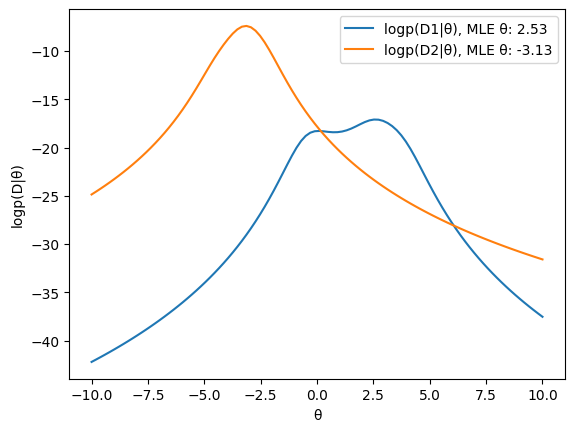

In [74]:
# initialize the MLE classifier
bayes = Classifier()

# find best parameters
MLE_1 = bayes.fit(D1)
MLE_2 = bayes.fit(D2)

# plot l(D1|theta) and l(D2|theta)
plt.plot(thetas, bayes.l(D1))
plt.plot(thetas, bayes.l(D2))

plt.xlabel("θ")
plt.ylabel("logp(D|θ)")
plt.legend([f'logp(D1|θ), MLE θ: {MLE_1:.2f}', f'logp(D2|θ), MLE θ: {MLE_2:.2f}'])

plt.show()

## Remarks

The theta parameter for the no stress class is approximately equal to 2.53,
whereas for the stress class is approximately equal to -3.13. Having found those,
we can now use g(x) to classify any given sample.

## 2. Classify the results and graph $g(x)$

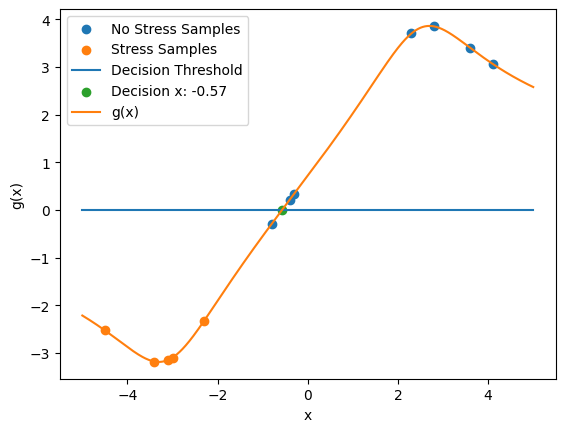

In [75]:
# create an axis for g(x)
x = np.linspace(-5, 5, 1000)
g_x = bayes.predict(x)
# get the 
decision = x[np.abs(g_x).argmin()]

plt.scatter(D1, bayes.predict(D1))
plt.scatter(D2, bayes.predict(D2))

plt.plot(x, np.zeros(x.shape))
plt.scatter(decision, np.zeros((1,)))
plt.plot(x, g_x)
plt.legend(['No Stress Samples',
            'Stress Samples',
            'Decision Threshold',
            f'Decision x: {decision:.2f}',
            'g(x)'])

plt.xlabel('x')
plt.ylabel('g(x)')
plt.show()

## Remarks

First of all, the boundary limit for x is -0.56. This indicates that any x, less than that,
is going to be classified as a stress sample. On the contrast, any sample with an x greater
than -0.56, is going to classified as a no stress sample.

From the graph, we can see that a no stress sample has been classified a stress sample.

Furthermore, we can see that no stress samples usually reside around 3, while stress samples
reside around -3.5.

---

# Part B: Bayesian Parameter Estimation
---
---

This approach has a simple decision rule:

For a given $x$, $h(x)$ is greater than or equal to 0, if x belongs to class $\omega_{1}$,
otherwise it belongs to class $\omega_{2}$. I calculate $h(x)$ using the formula below:
$$h(x) = log{P(x|D{_1})} - log{P(x|D{_2})} + log{P(\omega{_1})} - log{P(\omega{_2})}$$

where $$P(x|D) = \int p(x|\theta)p(\theta|D)\, d\theta$$

where $$p(\theta|D) = \frac{p(D|\theta)p(\theta)}{\int p(D|\theta)p(\theta)\, d\theta}$$

where $$ p(D|\theta) = \prod_{k=1}^{n} p(x_{k}|\theta)$$

Side-Note: Rule of Trapezoid

$$\int_{a}^{b} f(x)\, dx \approx \frac{h}{2}(f(x_0) + \sum_{k=1}^{n-1}f(x_k) + f(x_n))$$
where $$h = \frac{b-a}{n}$$

## 0. Implement BPE Classifier

In [76]:
# setup h for the rule of trapezoid
h = (thetas[-1] - thetas[0]) / len(thetas)

class Classifier:

        def __init__(self):
                pass
        
        # create p(x|theta) given x and theta (no, don't wrap it around ln)
        def p_x_theta(self, x, theta):
                return (1 / np.pi) * (1 / (1 + (x - theta) ** 2))
        
        # compute p(theta) from the theta axis defined above
        def p_theta(self):
                return (1 / (10 * np.pi)) * (1 / (1 + (thetas / 10) ** 2))
        
        # given D, compute p(D|theta)
        def p_D_theta(self, D):
                p_x_theta = np.frompyfunc(self.p_x_theta, 2, 1)
                return np.fromiter((np.prod(p_x_theta(D, theta)) for theta in thetas), float)
        
        # given D, compute p(theta|D), using the rule of trapezoid
        def p_theta_D(self, D):
                f = np.multiply(self.p_D_theta(D), self.p_theta())
                return f / self.integral(f)
        
        # given x and D, compute p(x|D) with the same rule
        def p_x_D(self, x, D):
                f = np.multiply(self.p_x_theta(x, thetas), self.p_theta_D(D))
                return self.integral(f)       

        # implement h for a single x
        def h(self, x):
                return np.log(self.p_x_D(x, D1)) \
                        - np.log(self.p_x_D(x, D2)) \
                                + np.log(P1) \
                                        - np.log(P2)
        
        # predict uses h for all x in set D
        def predict(self, D):
                return np.fromiter((self.h(x) for x in D), float)
        
        # implement rule of trapezoid
        def integral(self, f):
                return (h / 2) * (f[0] + 2 * np.sum(f[1:-1]) + f[-1])

## 1. Graph $p(\theta|D{_1})$ and $p(\theta|D{_2})$

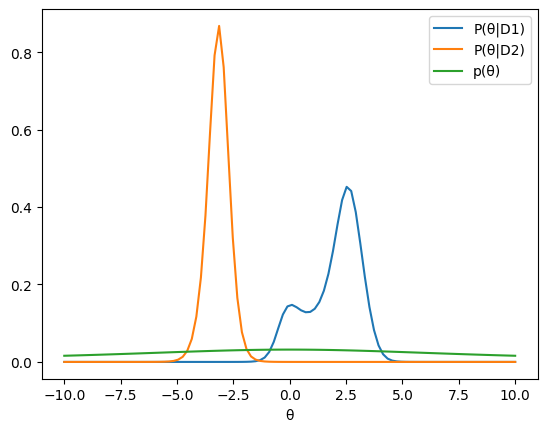

In [77]:
# initialize BPE Classifier
bayes = Classifier()
plt.plot(thetas, bayes.p_theta_D(D1))
plt.plot(thetas, bayes.p_theta_D(D2))
plt.plot(thetas, bayes.p_theta())
plt.legend(['P(θ|D1)', 'P(θ|D2)', 'p(θ)'])
plt.xlabel('θ')
plt.show()

## Remarks

No idea

## 2. Classify the results and graph $h(x)$

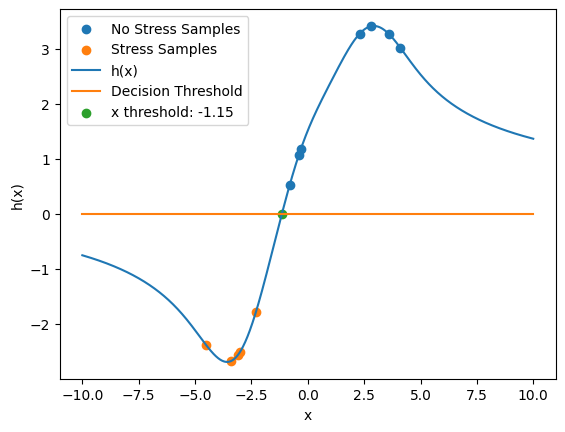

In [78]:
x = np.linspace(-10, 10, 1000)
h_x = bayes.predict(x)

decision = x[np.abs(h_x).argmin()]

plt.scatter(D1, bayes.predict(D1))
plt.scatter(D2, bayes.predict(D2))
plt.plot(x, h_x)
plt.plot(x, np.zeros(x.shape))
plt.scatter(decision, np.zeros((1,)))
plt.legend(['No Stress Samples', 'Stress Samples', 'h(x)', 'Decision Threshold', f'x threshold: {decision:.2f}'])
plt.xlabel('x')
plt.ylabel('h(x)')
plt.show()

## Remarks

We can see that h correctly classifies all the samples. Furthermore, the samples
that were very close to being misclassified, are now safe.

---